**Imports and workspace setting**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
plt.style.use('ggplot')

**Loading data file**

In [39]:
cancerData = pd.read_csv('../data/breast-cancer-wisconsin.data', header=None)
cancerData.drop(cancerData.columns[0],axis=1,inplace=True)
cancerData = cancerData.replace('?', np.nan)
cancerData.head()

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


**Stats of the data**

In [40]:
cancerData.shape

(699, 10)

**Class distribution of benign (2) and malignant (4)**

Class distribution is skewed towards benign.

Text(0.5, 0, 'Class')

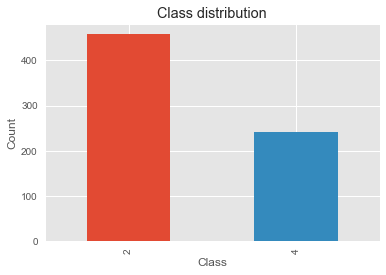

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
axes = cancerData[10].value_counts().plot(kind='bar', title='Class distribution')
axes.set_ylabel('Count')
axes.set_xlabel('Class')

**Drop missing values (16 values with ? mark)**

In [42]:
cancerDataAfterMissingValuesDropped = cancerData.dropna()
cancerDataAfterMissingValuesDropped.shape

(683, 10)

In [43]:
y = cancerDataAfterMissingValuesDropped.values[:,-1]
y=y.astype('int')
y.shape

(683,)

In [44]:
X = cancerDataAfterMissingValuesDropped.values[:,:-1]
X=X.astype('int')
X.shape

(683, 9)

**Holdout to create training (65%) and testing (35%) dataset**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=8)
print (str(X_train.shape) +","+ str(y_train.shape))
print (str(X_test.shape) +","+ str(y_test.shape))

(443, 9),(443,)
(240, 9),(240,)


**Parameter tuning of SVC**

In [46]:
svc_for_tuning = SVC(class_weight='balanced')

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

svc_gscv = GridSearchCV(svc_for_tuning, param_grid, cv=10, iid=True)
svc_gscv.fit(X_train, y_train)
svc_gscv.best_params_

{'C': 1, 'gamma': 0.01}

**Fit SVC with the parameters found using cross validation**

In [47]:
svc = SVC(**svc_gscv.best_params_, class_weight='balanced')
svc.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
predictions = svc.predict(X_test)

In [49]:
score = svc.score(X_test, y_test)
print('Accuracy score = ', score)

Accuracy score =  0.9791666666666666


**Classification report**

In [50]:
target_names = ['2 (benign)', '4 (malignant)']
print(metrics.classification_report(y_test,predictions, target_names=target_names, digits=3))

               precision    recall  f1-score   support

   2 (benign)      0.993     0.973     0.983       147
4 (malignant)      0.958     0.989     0.974        93

    micro avg      0.979     0.979     0.979       240
    macro avg      0.976     0.981     0.978       240
 weighted avg      0.980     0.979     0.979       240



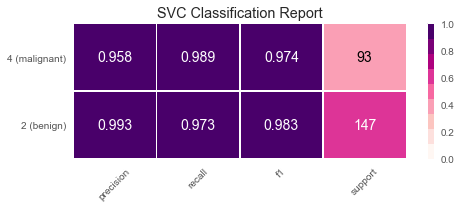

In [51]:
fig, ax = plt.subplots(figsize=(7,3))
visualizer = ClassificationReport(svc, classes=target_names, support=True, cmap='RdPu')
visualizer.score(X_test, y_test)
for label in visualizer.ax.texts:
    label.set_size(14)
g = visualizer.poof()

**Confusion metrix**

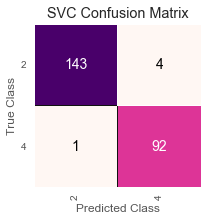

In [52]:
fig, ax = plt.subplots(figsize=(3,3))
cm = ConfusionMatrix(svc, classes=[2,4], cmap='RdPu')
cm.score(X_test, y_test)
for label in cm.ax.texts:
    label.set_size(14)
cm.poof()

**Conclusion**
01. Model works really well and provides 97.9% accuracy.
02. Default rbf kernel was used for SVC.
02. Parameter tuning improves the accuracy about 2%. Panelty parameter C of the error term and gamma is tuned using cross validation.
03. SVC does not have a method to weight the class distribution like in LogisticRegression. This is done using setting class_weight='balanced'. This reduces the impact on measures of skewed class and only 1 false negative (classifying malignent as benign) scenario is seen in the confution metrix which is good.